# Street processing


The goal of this file is to
* Process the 1836 dataset (finding / working with duplicate streets)
* Define which streets belong to only one or both datasets
* Have one final dataset containing all georeferenced streets

In [1]:
# Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from shapely.ops import linemerge, Point
#from importnb import Notebook
from preprocessing import preprocess
from collections import Counter
from duplicate_methods import duplicate_processing, duplicate_final

In [2]:
# Import shapefiles
Openparis = gpd.read_file("data/voie.zip", encoding = 'utf-8')
Vasserot = gpd.read_file("data/vasserot.zip")

# Set right EPSG for Geodata
Openparis = Openparis.to_crs(epsg=3857)
Vasserot = Vasserot.to_crs(epsg=3857)


## Preprocess streets with leas code

In [3]:
Openparis = preprocess(Openparis, "l_longmin")
Vasserot = preprocess(Vasserot, "NOM_ENTIER")

# TODO Rename those streets
Vasserot["voie"] = Vasserot["NOM_ENTIER_prep"]
Openparis["voie"] = Openparis["l_longmin_prep"]

# Remove empty lines
Vasserot = Vasserot.dropna(subset=["voie"])

# Add year
Vasserot = Vasserot.assign(year= [[1836]]*len(Vasserot))
Openparis = Openparis.assign(year= [[2022]]*len(Openparis))

# create buffer around streets, important for merging duplicate streets
buffer = 40
Vasserot["buffer"] = Vasserot["geometry"].apply(lambda x: x.buffer(buffer))
Openparis["buffer"] = Openparis["geometry"].apply(lambda x: x.buffer(buffer))


# Find all duplicates
Duplicates = Vasserot[Vasserot.duplicated(subset=['voie'], keep=False)].sort_values("voie")
Unique = Vasserot[~Vasserot.duplicated(subset=['voie'], keep=False)].sort_values("voie")


In [4]:
Vasserot.loc[1,"year"]

[1836]


## Process 1836 streets

### Duplicate work

#### Merge duplicates if close ("Overlapping" streets)

In [5]:
DuplicatesProcessed = duplicate_processing(Duplicates, "voie")

# Sanity check if all streetnames are in the newly created dataframe
#len(Duplicates["voie"].unique()) == DuplicatesProcessed["voie"].unique()))

c:\Users\Ben\doc\uni\22HS\FDH\paris\duplicate_methods.py:55: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  Dataframe["matching"] = pd.np.empty((len(Dataframe), 0)).tolist()
c:\Users\Ben\miniconda3\envs\paris\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Ben\miniconda3\envs\paris\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\Ben\doc\uni\22HS\FDH\paris\dupl

In [6]:
DuplicatesProcessed = gpd.GeoDataFrame(DuplicatesProcessed)

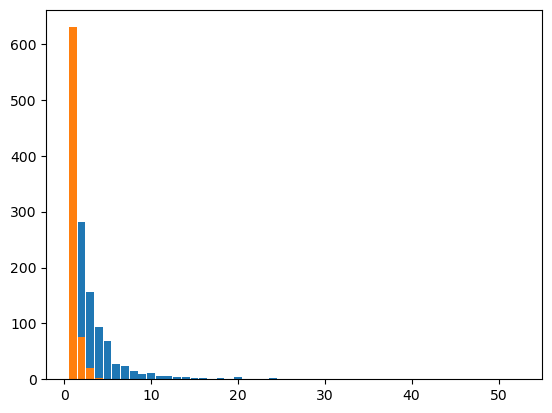

Duplicates before:  729
Duplicates after:  99


In [7]:
freqs = Counter(Duplicates["voie"].value_counts())
plt.bar(freqs.keys(), freqs.values(), width = 0.9)
freqs = Counter(DuplicatesProcessed["voie"].value_counts())
plt.bar(freqs.keys(), freqs.values(), width = 0.9)
plt.show()

print("Duplicates before: ", sum(Duplicates["voie"].value_counts()>1))
print("Duplicates after: ", sum(DuplicatesProcessed["voie"].value_counts()>1))

In [8]:
StillDuplicates = DuplicatesProcessed[DuplicatesProcessed.duplicated(subset=['voie'], keep=False)].sort_values("voie")
NewlyUnique = DuplicatesProcessed[~DuplicatesProcessed.duplicated(subset=['voie'], keep=False)].sort_values("voie")
# Adding newly unique streets
Unique = pd.concat([Unique, NewlyUnique])

#### Visualizing Streets that are still duplicates

In [9]:
StillDuplicates.geometry

3884    LINESTRING (257423.488 6248664.281, 257418.599...
583     LINESTRING (257413.524 6249078.624, 257413.946...
3813    LINESTRING (256545.627 6249360.411, 256377.556...
752     LINESTRING (256869.406 6249697.366, 256878.989...
360     LINESTRING (257640.278 6248771.516, 257629.325...
                              ...                        
1091    LINESTRING (264960.127 6250040.016, 264957.268...
867     LINESTRING (259565.306 6250836.079, 259543.115...
1592    LINESTRING (255034.498 6251828.064, 255039.782...
2072    LINESTRING (260007.674 6251883.986, 260001.150...
1035    LINESTRING (264285.715 6249063.925, 264304.092...
Name: geometry, Length: 242, dtype: geometry

In [10]:
# Needed in order to visualize results
StillDuplicates = StillDuplicates.drop(columns=["buffer"])

In [11]:
# Select Street to visualize
a = StillDuplicates["voie"].value_counts()[StillDuplicates["voie"].value_counts()>=2]
Trueduplicates = a.index
mask = StillDuplicates["voie"] == Trueduplicates[8]
# Visualize
StillDuplicates[mask].explore()

 
## Find matching streets of both datasets


#### Preparing Vasserot and Openparis dataframe for final comparison

In [12]:
# Unique from Vasserot DF
Unique = Unique.iloc[:,[0,8,14,16,17,18]]
Unique = Unique.rename(columns={"ROWID":"rowid", "NOM_ENTIER":"name_original"})
Unique = Unique.assign(matching = [[]] * len(Unique))

In [13]:
# Uniques from Openparis DF
Openparis = Openparis.iloc[:,[6,15,17,18,19]]
Openparis = Openparis.rename(columns={"l_longmin": "name_original"})
# assign random rowid to Openparis data because they dont have them
Openparis = Openparis.assign(rowid = np.random.randint(7000, 200000, size=len(Openparis)))
Openparis = Openparis.assign(matching = [[]] * len(Openparis))

Merged = pd.concat([Unique, Openparis])
Merged


,rowid,name_original,geometry,voie,year,buffer,matching
2374,2375,Allée Marboeuf,"LINESTRING (256709.197 6252932.608, 256668.651...",allee marboeuf,[1836],POLYGON ((256290.78859586542 6252459.184508624...,[]
1082,1083,Avenue de l'Arsenal,"LINESTRING (263598.227 6249748.699, 263556.945...",avenue de l'arsenal,[1836],"POLYGON ((263589.6000183587 6249667.24046653, ...",[]
1073,1074,Avenue des Triomphes,"LINESTRING (267115.878 6249542.645, 267078.529...",avenue des triomphes,[1836],POLYGON ((267108.77228366205 6249473.337036237...,[]
1680,1681,Avenue des Trois Frères,"LINESTRING (263776.291 6250990.224, 263783.362...",avenue des trois freres,[1836],"POLYGON ((263769.9203242211 6251030.420161021,...",[]
1028,1029,Avenue du Bel Air,"LINESTRING (267057.188 6248665.633, 267041.820...",avenue du bel air,[1836],POLYGON ((267005.77170487825 6248680.255100895...,[]
...,...,...,...,...,...,...,...
6537,143127,Voie Di/19,"LINESTRING (265842.047 6258079.918, 265850.032...",voie di/19,[2022],POLYGON ((265810.56986268243 6258134.655396614...,[]
6538,93874,Voie F/11,"LINESTRING (263945.860 6252546.483, 263988.205...",voie f/11,[2022],POLYGON ((264025.7212023547 6252445.8801847175...,[]
6539,199375,Voie Aw/14,"LINESTRING (258726.087 6244468.096, 258595.856...",voie aw/14,[2022],"POLYGON ((258583.91800858144 6244472.47844539,...",[]
6540,152465,Chemin de la Croix Catelan,"LINESTRING (251045.314 6252171.705, 251044.678...",chemin de la croix catelan,[2022],POLYGON ((251084.96265877737 6252161.805162983...,[]


In [14]:
UniqueProcessed = duplicate_final(Unique, "voie")

c:\Users\Ben\doc\uni\22HS\FDH\paris\duplicate_methods.py:98: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  Dataframe["matching"] = pd.np.empty((len(Dataframe), 0)).tolist()
c:\Users\Ben\miniconda3\envs\paris\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [15]:
FinalDuplicates = UniqueProcessed[UniqueProcessed.duplicated(subset=['voie'], keep=False)].sort_values("voie")
FinalUnique= UniqueProcessed[~UniqueProcessed.duplicated(subset=['voie'], keep=False)].sort_values("voie")


In [22]:
max(FinalUnique["voie"].value_counts())
#FinalDuplicates
#UniqueProcessed["year"][800:900]


,rowid,name_original,geometry,voie,year,buffer,matching,filter


In [24]:
FinalUnique["geometry"].explore()


### "Overlapping" streets?
### Decide on single geometric representation
## Create different datasets
### Check if dataset is perfectly partitioned
### Make one dataset - add street type

 close ("Overlapping" streets)
## Find matching streets of both datasets
### "Overlapping" streets?
### Decide on single geometric representation
## Create different datasets
### Check if dataset is perfectly partitioned
### Make one dataset - add street type